In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
#import requests # API library

import random
import time
import os

#from isoweek import Week

#import requests # API library

import numpy as np
import pandas as pd
import json
import re

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuide, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive



In [15]:
def model3(obs, ids1, ids2, num_coaches):
    hyper_sigma = 1/8
    coach_skills = pyro.sample("coach_skill", dist.Normal(torch.zeros(num_coaches), hyper_sigma).to_event(1))

    with pyro.plate('matches', obs.shape[0]):   

        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach_skills[ids1], hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach_skills[ids2], hyper_sigma))

        perf_diff = coach1_perf - coach2_perf
    
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y


In [18]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

# tror noget gik galt med at gætte størrelser med en autoguide, så fik chatgpt til at lave en guide til os.
import pyro
import pyro.distributions as dist
import torch

def guide3(obs, ids1, ids2, num_coaches):
    hyper_sigma = 1/8
    
    # Guide parameters for coach skills
    coach_skill_loc = pyro.param("coach_skill_loc", torch.zeros(num_coaches))
    coach_skill_scale = pyro.param("coach_skill_scale", torch.ones(num_coaches) * hyper_sigma, constraint=dist.constraints.positive)
    
    # Sample the coach skills using the guide's parameters
    coach_skills = pyro.sample("coach_skill", dist.Normal(coach_skill_loc, coach_skill_scale).to_event(1))
    
    with pyro.plate('matches', obs.shape[0]):
        # Guide parameters for coach1 performance
        coach1_perf_loc = pyro.param("coach1_perf_loc", torch.zeros(obs.shape[0]))
        coach1_perf_scale = pyro.param("coach1_perf_scale", torch.ones(obs.shape[0]) * hyper_sigma, constraint=dist.constraints.positive)
        
        # Guide parameters for coach2 performance
        coach2_perf_loc = pyro.param("coach2_perf_loc", torch.zeros(obs.shape[0]))
        coach2_perf_scale = pyro.param("coach2_perf_scale", torch.ones(obs.shape[0]) * hyper_sigma, constraint=dist.constraints.positive)
        
        # Sample the coach performances using the guide's parameters
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_perf_loc, coach1_perf_scale))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_perf_loc, coach2_perf_scale))

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 12
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 397.48328137397766
Step 100 : loss = 15.093380689620972
Step 200 : loss = 15.718668818473816
Step 300 : loss = 10.16081190109253
Step 400 : loss = 11.963497877120972
Step 500 : loss = 9.637521266937256
Step 600 : loss = 11.21036148071289
Step 700 : loss = 15.518939971923828
Step 800 : loss = 10.287728309631348
Step 900 : loss = 13.81022596359253
Step 1000 : loss = 12.037503719329834
Step 1100 : loss = 10.630983829498291
Step 1200 : loss = 9.72007131576538
Step 1300 : loss = 7.468456745147705
Step 1400 : loss = 11.661979675292969
Step 1500 : loss = 13.994187831878662
Step 1600 : loss = 9.06961727142334
Step 1700 : loss = 14.405285954475403
Step 1800 : loss = 8.092464447021484
Step 1900 : loss = 15.99612283706665
Step 2000 : loss = 13.085401058197021
Step 2100 : loss = 15.331648349761963
Step 2200 : loss = 9.526411533355713
Step 2300 : loss = 15.318283557891846
Step 2400 : loss = 7.439457893371582
Step 2500 : loss = 10.66318941116333
Step 2600 : loss = 9.41365909576416
St

In [22]:
from pyro.infer import Predictive

predictive = Predictive(model3, guide=guide, num_samples=2000)
                        #return_sites=("coach_skill", "coach_skill"))

samples = predictive(obs,id1, id2, num_coaches)


ValueError: Shape mismatch inside plate('matches') at site coach1_perf dim -1, 12 vs 2
   Trace Shapes:       
    Param Sites:       
   Sample Sites:       
coach_skill dist    | 2
           value  1 | 2
    matches dist    |  
           value 12 |  

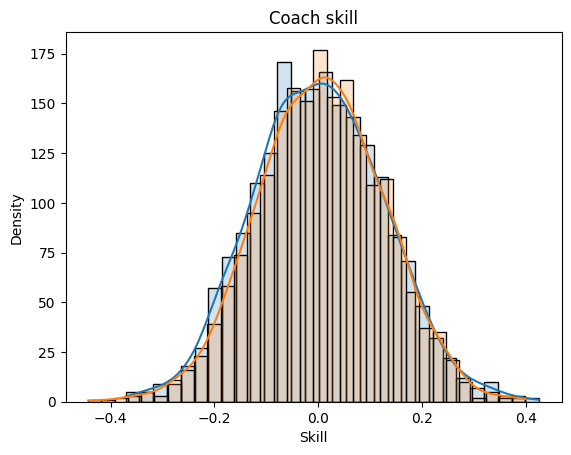

In [ ]:
import seaborn as sns

coach1_skill = samples["coach_skill"].detach().squeeze()[:,0]
coach2_skill = samples["coach_skill"].detach().squeeze()[:,1]

sns.histplot(coach1_skill, kde=True, alpha=0.2,legend="Coach 1")
sns.histplot(coach2_skill, kde=True, alpha=0.2,legend="Coach 2")
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()